In [3]:
from typing import List, TypedDict
import time
import os

from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_groq import ChatGroq
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate

from langgraph.graph import START, StateGraph, END

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

C:\Users\004NQ8744\OneDrive\Roadwork\langChain\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
groq_api_key = os.getenv("GROQ_API_KEY")
# llm=ChatGroq(groq_api_key=groq_api_key,model_name="Gemma2-9b-It")
llm = ChatGroq(groq_api_key=groq_api_key, model_name="llama-3.1-8b-instant")

In [7]:
docs = (
    PyPDFLoader("./documents/book1.pdf").load() +
    PyPDFLoader("./documents/book2.pdf").load()
)


In [8]:
len(docs)

1559

In [9]:
chunks = RecursiveCharacterTextSplitter(chunk_size=900, chunk_overlap=150).split_documents(docs)

Clean text to avoid UnicodeEncodeError (surrogates from PDF extraction)

In [10]:
for chunk in chunks:
    chunk.page_content = chunk.page_content.encode("utf-8", "ignore").decode("utf-8", "ignore")

In [11]:
len(chunks)

5033

In [12]:
vector_store = FAISS.from_documents(chunks, embeddings)

In [13]:
retriever = vector_store.as_retriever(search_type="similarity", search_kwargs={'k':4})

In [14]:
class State(TypedDict):
    question: str
    docs: List[Document]
    answer: str

In [15]:
def retrieve(state):
    q = state["question"]
    return {"docs": retriever.invoke(q)}

In [16]:
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "Answer only from the context. If not in context, say you don't know."),
        ("human", "Question: {question}\n\nContext:\n{context}"),
    ]
)

In [23]:
def generate(state):
    context = "\n\n".join(doc.page_content for doc in state["docs"])
    output = (prompt | llm).invoke({"question": state["question"], "context": context})
    return {"answer": output.content}

In [24]:
g = StateGraph(State)
g.add_node("retrieve", retrieve)
g.add_node("generate", generate)
g.add_edge(START, "retrieve")
g.add_edge("retrieve", "generate")
g.add_edge("generate", END)

app = g.compile()

In [19]:
app

CompiledStateGraph(nodes={'__start__': PregelNode(config={'tags': ['langsmith:hidden']}, channels=['__start__'], triggers=['__start__'], writers=[ChannelWrite<question,docs,answer>(recurse=True, writes=[ChannelWriteEntry(channel='question', value=<object object at 0x000001E3372FAEC0>, skip_none=False, mapper=_get_state_key(recurse=False)), ChannelWriteEntry(channel='docs', value=<object object at 0x000001E3372FAEC0>, skip_none=False, mapper=_get_state_key(recurse=False)), ChannelWriteEntry(channel='answer', value=<object object at 0x000001E3372FAEC0>, skip_none=False, mapper=_get_state_key(recurse=False))]), ChannelWrite<start:retrieve>(recurse=True, writes=[ChannelWriteEntry(channel='start:retrieve', value='__start__', skip_none=False, mapper=None)])]), 'retrieve': PregelNode(config={'tags': []}, channels={'question': 'question', 'docs': 'docs', 'answer': 'answer'}, triggers=['start:retrieve'], mapper=functools.partial(<function _coerce_state at 0x000001E338953240>, <class '__main__.S

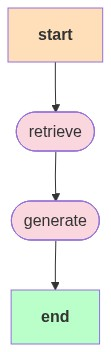

In [28]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [26]:
res = app.invoke({"question": "WHat is a transformer in deep learning.", "docs": [], "answer": ""})
print(res["answer"])

I don't know


In [27]:
res = app.invoke({"question": "What is deep learning.", "docs": [], "answer": ""})
print(res["answer"])

Deep learning is a type of artificial neural network that represents functions of increasing complexity by adding more layers and more units within a layer. It is a powerful framework for supervised learning and has a long history, dating back to the 1940s, although it has undergone several name changes and periods of increased and decreased popularity over the years.
